
# **3-2 - Churn Analysis**

Marketing and Customer Analytics

In [1]:
# Load data manipulation package
import numpy as np
import pandas as pd

# Load data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# display all columns
pd.set_option('display.max_columns', None)

# 1. Business Understanding
---

- Knowing customer churn is essential for internet provider company for effectively prevent them using appropriate marketing initiative
- Internet provider company wants to give specific marketing initiative for preventing customer churn

## 1.1 Business Objective
---

- Reduce 10% customer churn in the next period year
- Identify the relationship between predictors and target variable
- company wants to prevent unnecessary allocation of resources and efforts towards non-churn customers (they set threshold maximum allowed false positives is 50%)

**Given Information**

There are 2 types of marketing cost in this case:
- cost acquisition (cost to acquire new customers) --> \$50 / customer
- cost reactivation (cost to retain existing customers) --> \$15 / customer

## 1.2 Business Question
---

- How can internet provider company develop marketing effectiveness strategy to reduce 10% of churn?
- What marketing initiatives are suitable to reduce the 10% customer churn?
- How to prevent unnecessary budget allocation?

## 1.3. Modelling Task

- Output target: **customer status of churn (categorical)**

- The goal of this project is to predict whether a customer will churn or not based on various features.
Task: **Classification task**


- We need a model that can be easily interpreted so that we can understand how each feature contributes to the prediction. This can help us gain insights into the underlying factors that influence whether a customer will churn or not.
Model used: **Logistic regression**

- We will use ROC/AUC as our evaluation metric since we want it's not influeced by imbalance target and we need to measure threshold using ROC/AUC.

**Evaluation metric: ROC/AUC and Precision**

## 1.4 Customer Churn Definition

- Customer who has purchase event before defined time window
- Customer who has no purchase event in defined 5 weeks time window

# 2. Modelling Workflow
---

### 1. <font color='blue'> Importing Data to Python</font>
    * Data validation
### 2. <font color='blue'> Data Spliting</font>
    * Split data based on observation log period
### 3. <font color='blue'> Exploratory Data Analysis</font>
    * Explore variables, build customer cohort, gaining business insights
### 4. <font color='blue'> Data Preprocessing</font>
    * Missing value handling, feature engineering, and normalization
### 5. <font color='blue'> Modelling</font>
    * Modelling and evaluation
### 6. <font color='blue'> Targeting the Right Customers</font>
    * Lift curve
### 7. <font color='blue'> Interpretation & Business Recommendation </font>
    * Gaining insights

# 3. Importing Data
---

## 3.1 Data Description

The data set contains 500K rows and 8 columns. The following is the description of each column.

- `TransactionNo` (categorical): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.

- `Date` (numeric): the date when each transaction was generated.

- `ProductNo` (categorical): a five or six-digit unique character used to identify a specific product.

- `Product` (categorical): product/item name.

- `Price` (numeric): the price of each product per unit in pound sterling (£).

- `Quantity` (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.

- `CustomerNo` (categorical): a five-digit unique number that defines each customer.


[Original Dataset](https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business)

## 3.2 Import Data

In [2]:
# read dataset function
def read_data(path):
    """
    Reads a CSV file at the given path, removes any duplicate rows,
    and returns its contents as a pandas DataFrame.

    Parameters
    ----------
    path : str
        input path

    Returns
    -------
    df : pandas Dataframe
        Sample dataframe
    """
    # 1. Read data
    data = pd.read_csv(path, index_col = 0)
    print('Original data shape :', data.shape)

    # 2. Change the data types
    data['Date'] = pd.to_datetime(data['Date'])

    # 3. Filter out 2018
    data = data[data['Date'] > pd.to_datetime('2018-12-31')]
    data = data.reset_index(drop=True)

    # 4. Drop duplicates
    data = data.drop_duplicates()
    print('Dropped data shape  :', data.shape)

    return data


In [3]:
# Read data
data = read_data(path = 'data_retail.csv')
data.head()

Original data shape : (232201, 7)
Dropped data shape  : (232201, 7)


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12.0,17490.0
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36.0,13069.0
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12.0,13069.0
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12.0,13069.0
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6.0,13069.0


In [4]:
# check data type
data.dtypes

,0
TransactionNo,int64
Date,datetime64[ns]
ProductNo,object
ProductName,object
Price,float64
Quantity,float64
CustomerNo,float64


In [5]:
# check missing
data.isna().sum()

,0
TransactionNo,0
Date,0
ProductNo,0
ProductName,0
Price,1
Quantity,1
CustomerNo,1


# 4 Data Spliting
---

In [6]:
print(f"First Transaction : {data['Date'].min()}")
print(f"Last Transaction : {data['Date'].max()}")

First Transaction : 2019-07-22 00:00:00
Last Transaction : 2019-12-09 00:00:00


In [7]:
def create_observation_period_log(data):
    """
    Create the weekly observation period log table
    based on the provided DataFrame.

    Parameter
    ---------
    data: pandas DataFrame
        Input DataFrame containing transaction data.

    Return
    ------
    data_log: pandas DataFrame
        Weekly observation period log table with
        customers as rows and weeks as columns.

    data_stamped : pandas DataFrame
        Sample data with week information
    """
    data = data.copy()

    # Group the data by customer and week
    data['Week'] = data['Date'].dt.isocalendar().week
    data['WeekStart'] = data['Date'].dt.to_period('W').dt.start_time
    data['WeekEnd'] = data['Date'].dt.to_period('W').dt.end_time

    # Obtain unique customer & unique week
    unique_cust = sorted(set(data['CustomerNo']))
    unique_week = sorted(set(data['Week']))

    # Create the weekly observation period log table
    max_week = max(unique_week)
    data_log = pd.DataFrame(np.zeros((len(unique_cust), max_week), dtype=int))
    data_log.index = unique_cust
    data_log.columns = list(range(1, max_week + 1))
    # Iterate over each customer group
    for customer_id, group in data.groupby('CustomerNo'):
        # Obtain the week where customer do transactions
        week_purchase = list(set(group['Week']))

        # Fill the data log
        data_log.loc[customer_id, week_purchase] = 1

    data_stamped = data

    return data_log, data_stamped


In [8]:
data_log, data_stamped = create_observation_period_log(data)

In [9]:
# shanity check
print(data_log.shape)
data_log.head()

(3113, 50)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
12031.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
12057.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
12067.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
12115.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12130.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [10]:
# shanity check
print(data_stamped.shape)
data_stamped.head()

(232201, 10)


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Week,WeekStart,WeekEnd
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12.0,17490.0,50,2019-12-09,2019-12-15 23:59:59.999999999
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36.0,13069.0,50,2019-12-09,2019-12-15 23:59:59.999999999
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12.0,13069.0,50,2019-12-09,2019-12-15 23:59:59.999999999
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12.0,13069.0,50,2019-12-09,2019-12-15 23:59:59.999999999
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6.0,13069.0,50,2019-12-09,2019-12-15 23:59:59.999999999


In [11]:
def split_historical_future_data(data_log, time_sep):
    """
    Split the observation period log data into training & testing sets

    Parameters
    ----------
    data_log : pandas DataFrame
          Sample of data log

    time_sep : str
          Time separator to separate the data,
          in 'YYYY-MM-DD' format

    Returns
    -------
    data_log_train : pandas DataFrame
          Sample of train data log

    data_log_test : pandas DataFrame
          Sample of test data log
    """
    # Set time separator
    time_separator = pd.to_datetime(time_sep)

    # Convert time separator to week separator
    condition_sep = data_stamped['Date'] < time_separator

    # Handle potential missing values in 'Week' column
    week_separator = data_stamped[condition_sep]['Week'].max()
    if pd.isna(week_separator):
        # Replace with a suitable default value if necessary
        week_separator = data_stamped['Week'].max()

    # Split train & test data log
    data_log_historical = data_log.loc[:, :week_separator]
    data_log_future = data_log.loc[:,:]

    print('Data log historical shape     :', data_log_historical.shape)
    print('Data log future shape      :', data_log_future.shape)

    return data_log_historical, data_log_future

In [12]:
data_log_historical, data_log_future = split_historical_future_data(data_log = data_log,
                                                                    time_sep = '2019-08-28') # approximately week 35

Data log historical shape     : (3113, 35)
Data log future shape      : (3113, 50)


In [13]:
data_log_historical.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
12031.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12057.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12067.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12115.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12130.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# check customer with 1 minimum transaction
print(f"Number of all customers: {data_log_historical.shape[0]}")
print(f"Number of customer with transaction event in historical log: {data_log_historical[data_log_historical.sum(axis=1)>0].shape[0]}")

Number of all customers: 3113
Number of customer with transaction event in historical log: 1103


In [15]:
data_log_future.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
12031.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
12057.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
12067.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
12115.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12130.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [16]:
# check customer with 1 minimum transaction
print(f"Number of all customers: {data_log_future.shape[0]}")
print(f"Number of customer with transaction event in future log: {data_log_future[data_log_future.sum(axis=1)>0].shape[0]}")

Number of all customers: 3113
Number of customer with transaction event in future log: 3112


In [17]:
def log_period_separation(log_data, obs_period, time):
    """
    Function to separate log period data and data for anotation

    Parameters
    ----------
    log_data: pandas dataframe
          log data for each week purchase event

    obs_period: int
          churn observation period (time window) in weeks

    time: str
          time separator

    returns
    -------
    log_period_data: pandas dataframe
          log period data for observation

    data_for_anotation: pandas dataframe
          data for defining churn (time window)
    """
    # define time separator
    time_sep = pd.to_datetime(time)
    cond_sep = data_stamped['Date'] < time_sep
    week_sep = data_stamped[cond_sep]['Week'].max()

    # filter data
    data_log_filtered = log_data[log_data.sum(axis=1)>0]

    # separate data
    data_log_obs =  data_log_filtered.iloc[:, :week_sep-obs_period]
    data_for_anotation = data_log_filtered.iloc[:, week_sep-obs_period:]

    return data_log_obs, data_for_anotation

In [18]:
log_period_his_data, data_his_for_anotation = log_period_separation(log_data = data_log_historical,
                                                                    obs_period = 5,
                                                                    time = '2019-08-29')

In [19]:
# historical data log_period
log_period_his_data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
12160.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12221.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12230.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12610.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# historical data for anotation
data_his_for_anotation

,31,32,33,34,35
12160.0,0,0,1,0,0
12221.0,0,0,0,1,0
12230.0,0,0,0,1,0
12350.0,1,0,0,0,0
12610.0,0,1,0,1,0
...,...,...,...,...,...
18248.0,0,1,0,0,0
18257.0,0,0,1,0,0
18268.0,0,0,0,0,0
18272.0,0,0,1,0,0


In [21]:
def assign_customer_id(data_log, data_stamped, date):
    """
    Function to assign customer id

    Parameters
    ----------
    data_log: pandas dataframe
            log data with each week as the columns

    data_stamped: pandas dataframe
            transactional data

    Returns
    -------
    transaction_df: pandas dataframe
            transactional daa with filtered customers
    """
    # get customer id
    unique_cust = data_log.index.tolist()

    # filter data based on the date
    data_filtered = data_stamped[data_stamped['Date']<date]

    # filter data
    transaction_df = data_filtered[(data_filtered['CustomerNo'].isin(unique_cust))]

    return transaction_df

In [22]:
transaction_df = assign_customer_id(data_log = log_period_his_data,
                                    data_stamped = data_stamped,
                                    date = '2019-08-29')

In [23]:
# shanity check
print(transaction_df.shape)
transaction_df.head()

(35142, 10)


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Week,WeekStart,WeekEnd
197058,564727,2019-08-28,84078A,Set/4 White Retro Storage Cubes,51.20,1.0,16686.0,35,2019-08-26,2019-09-01 23:59:59.999999999
197059,564727,2019-08-28,22761,Chest 7 Drawer Ma Campagne,35.82,1.0,16686.0,35,2019-08-26,2019-09-01 23:59:59.999999999
197060,564727,2019-08-28,22782,Set 3 Wicker Storage Baskets,35.82,1.0,16686.0,35,2019-08-26,2019-09-01 23:59:59.999999999
197061,564727,2019-08-28,85161,Acrylic Geometric Lamp,29.67,1.0,16686.0,35,2019-08-26,2019-09-01 23:59:59.999999999
197062,564715,2019-08-28,22797,Chest Of Drawers Gingham Heart,27.62,1.0,14472.0,35,2019-08-26,2019-09-01 23:59:59.999999999


In [24]:
# shanity check
transaction_df['Date'].max()

Timestamp('2019-08-28 00:00:00')

In [25]:
def remove_unnecessary_cols(data):
    """
    Function to remove unnuecessary cols

    Parameter
    ---------
    data : pandas dataframe
        transactional data

    Return
    data_cust : pandas dataframe
        data with removed unnecessary cols
    """
    # remove unnecessary columns
    data_cust = data.drop(columns=['Week', 'WeekStart', 'WeekEnd'])

    return data_cust

In [26]:
transaction_data = remove_unnecessary_cols(data = transaction_df)

In [27]:
# shanity check
print(transaction_data.shape)
transaction_data.head()

(35142, 7)


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo
197058,564727,2019-08-28,84078A,Set/4 White Retro Storage Cubes,51.20,1.0,16686.0
197059,564727,2019-08-28,22761,Chest 7 Drawer Ma Campagne,35.82,1.0,16686.0
197060,564727,2019-08-28,22782,Set 3 Wicker Storage Baskets,35.82,1.0,16686.0
197061,564727,2019-08-28,85161,Acrylic Geometric Lamp,29.67,1.0,16686.0
197062,564715,2019-08-28,22797,Chest Of Drawers Gingham Heart,27.62,1.0,14472.0


In [28]:
# Split train test cust
from sklearn.model_selection import train_test_split

def train_valid_test_split(data, valid_size = 0.5, test_size = 0.2):
    """
    Function to split train valid and test

    Parameter
    ---------
    data: pandas dataframe
        data for spliting

    valid_size: int
        valid size in train_test_split, default 0.5

    test_seize: int
        test size in train_test_split, default 0.2
    Return
    ------
    data_train : pandas dataframe
        dataframe for training

    data_valid : pandas dataframe
        dataframe for validation

    data_test : pandas dataframe
        dataframe for testing
    """
    unique_cust = set(data['CustomerNo'])

    # split train test
    train_cust_list, test_val_cust_list = train_test_split(list(unique_cust),
                                                           test_size=test_size,
                                                           random_state=42)
    # split train test
    test_cust_list, valid_cust_list = train_test_split(list(test_val_cust_list),
                                                       test_size=valid_size,
                                                       random_state=42)
    # assign customer id training set
    train_data = data[(data['CustomerNo'].isin(train_cust_list))]

    # assign customer id valid set
    valid_data = data[(data['CustomerNo'].isin(valid_cust_list))]

    # assign customer id test set
    test_data = data[(data['CustomerNo'].isin(test_cust_list))]

    return train_data, valid_data, test_data

In [29]:
train_data, valid_data, test_data = train_valid_test_split(data = transaction_data,
                                                           valid_size = 0.5,
                                                           test_size = 0.2)

In [30]:
# check dimension
train_data.shape, valid_data.shape, test_data.shape

((27051, 7), (4213, 7), (3878, 7))

In [31]:
train_data.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo
197058,564727,2019-08-28,84078A,Set/4 White Retro Storage Cubes,51.20,1.0,16686.0
197059,564727,2019-08-28,22761,Chest 7 Drawer Ma Campagne,35.82,1.0,16686.0
197060,564727,2019-08-28,22782,Set 3 Wicker Storage Baskets,35.82,1.0,16686.0
197061,564727,2019-08-28,85161,Acrylic Geometric Lamp,29.67,1.0,16686.0
197062,564715,2019-08-28,22797,Chest Of Drawers Gingham Heart,27.62,1.0,14472.0


In [32]:
# check number of customer each dataset
len(set(train_data['CustomerNo'])), len(set(valid_data['CustomerNo'])), len(set(test_data['CustomerNo']))

(830, 104, 104)

# 5. Exploratory Data Analysis
---

In [33]:
# copy train_set data
eda = train_data.copy()

In [34]:
eda_anotation_data = data_his_for_anotation.copy()

In [35]:
# check dtypes
eda.dtypes

,0
TransactionNo,int64
Date,datetime64[ns]
ProductNo,object
ProductName,object
Price,float64
Quantity,float64
CustomerNo,float64


## EDA - PART 1
---

### 5.1 Check Missing Values
----

In [36]:
eda.isna().sum()

,0
TransactionNo,0
Date,0
ProductNo,0
ProductName,0
Price,0
Quantity,0
CustomerNo,0


### 5.2 Check Duplicated Values
---

In [37]:
print(f"Number of duplicated rows: {eda.duplicated().sum()}")

Number of duplicated rows: 0


### 5.3 Descriptive Statistics
---

In [38]:
eda.describe().T

,count,mean,min,25%,50%,75%,max,std
TransactionNo,27051.0,562822.597982,560924.0,561898.0,562784.0,563720.0,564746.0,1077.541114
Date,27051,2019-08-09 08:51:50.923810816,2019-07-22 00:00:00,2019-07-31 00:00:00,2019-08-09 00:00:00,2019-08-18 00:00:00,2019-08-28 00:00:00,NaN
Price,27051.0,12.752902,5.34,11.1,11.94,14.09,97.37,4.135022
Quantity,27051.0,12.495619,1.0,2.0,4.0,12.0,1900.0,39.543106
CustomerNo,27051.0,15426.558722,12160.0,14080.0,15356.0,16806.0,18282.0,1602.454119


### 5.4 `Date` Variable
---

In [39]:
print(f"First Transaction date : {eda['Date'].min()}")
print(f"Last Transaction date : {eda['Date'].max()}")

First Transaction date : 2019-07-22 00:00:00
Last Transaction date : 2019-08-28 00:00:00


### 5.5 `ProductNo` Variable
---

In [40]:
print(f" There are {eda['ProductNo'].nunique()} unique product sold in 1 year")

 There are 2419 unique product sold in 1 year


### 5.6 `Price` Variable
---

In [41]:
eda['Price'].describe()

,Price
count,27051.000000
mean,12.752902
std,4.135022
min,5.340000
25%,11.100000
50%,11.940000
75%,14.090000
max,97.370000


In [42]:
eda.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo
197058,564727,2019-08-28,84078A,Set/4 White Retro Storage Cubes,51.20,1.0,16686.0
197059,564727,2019-08-28,22761,Chest 7 Drawer Ma Campagne,35.82,1.0,16686.0
197060,564727,2019-08-28,22782,Set 3 Wicker Storage Baskets,35.82,1.0,16686.0
197061,564727,2019-08-28,85161,Acrylic Geometric Lamp,29.67,1.0,16686.0
197062,564715,2019-08-28,22797,Chest Of Drawers Gingham Heart,27.62,1.0,14472.0


Text(0.5, 1.0, 'Boxplot Price Distribution')

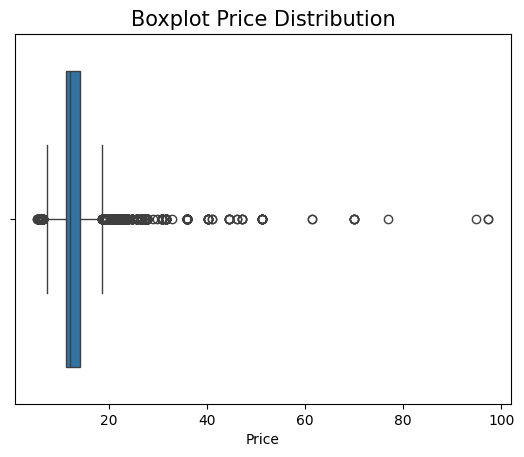

In [43]:
sns.boxplot(data = eda, x = 'Price')
plt.title('Boxplot Price Distribution', fontsize='15')

(0.0, 30.0)

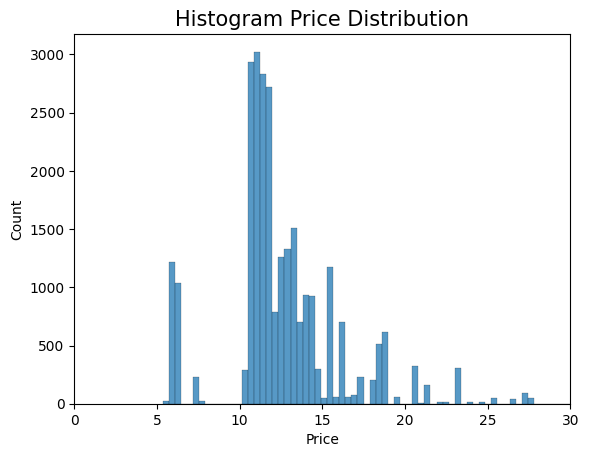

In [44]:
sns.histplot(data = eda, x = 'Price', bins=250)
plt.title('Histogram Price Distribution', fontsize='15')
plt.xlim(0,30)

### 5.7 `Quantity` Variable
---

Text(0.5, 1.0, 'Boxplot Quantity Distribution')

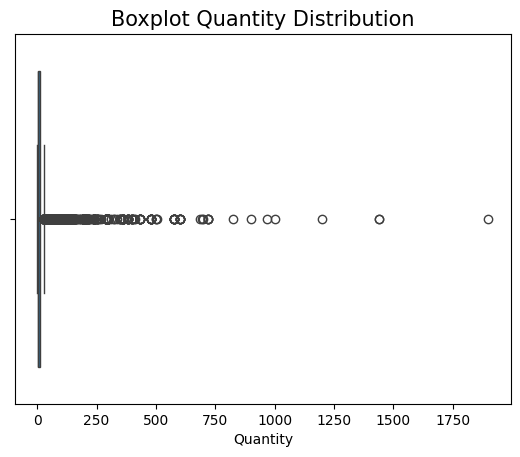

In [45]:
sns.boxplot(data = eda, x = 'Quantity')
plt.title('Boxplot Quantity Distribution', fontsize='15')

(0.0, 50.0)

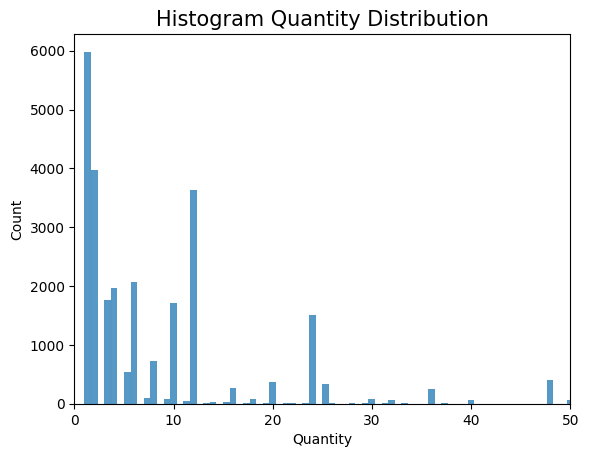

In [46]:
sns.histplot(data = eda, x = 'Quantity')
plt.title('Histogram Quantity Distribution', fontsize='15')
plt.xlim(0,50)

### 5.8 `TransactionNo`Variable
---

In [47]:
# check the data
print(f"Number of cancelled order : {eda['TransactionNo'].astype(str).str.contains('C').sum()}")

Number of cancelled order : 0


### 5.9 `CustomerNo` variable
---

In [48]:
print(f"Number of unique customer  : {eda['CustomerNo'].nunique()}")

Number of unique customer  : 830


## EDA - PART 2
---

### 5.10 Create RFM, Tenure, and AOV Variable
---

In [49]:
# check the first and last transaction
print(f"First Transaction date : {eda['Date'].min()}")
print(f"Last Transaction date : {eda['Date'].max()}")

First Transaction date : 2019-07-22 00:00:00
Last Transaction date : 2019-08-28 00:00:00


In [50]:
eda.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo
197058,564727,2019-08-28,84078A,Set/4 White Retro Storage Cubes,51.20,1.0,16686.0
197059,564727,2019-08-28,22761,Chest 7 Drawer Ma Campagne,35.82,1.0,16686.0
197060,564727,2019-08-28,22782,Set 3 Wicker Storage Baskets,35.82,1.0,16686.0
197061,564727,2019-08-28,85161,Acrylic Geometric Lamp,29.67,1.0,16686.0
197062,564715,2019-08-28,22797,Chest Of Drawers Gingham Heart,27.62,1.0,14472.0


In [51]:
# Define some functions

def calculate_recency(x):
    """Calculate the recency (days) based on the reference date"""
    # we set reference date as last purchase date based on the input data
    return (reference_date - x.max()).days

def calculate_tenure(x):
    """Calculate the tenure (days) based on the reference date"""
    return (x.max() - x.min()).days

def calculate_frequency(x):
    """Calculate the frequency based on the latest date"""
    return len(set(x))

def calculate_monetary(x):
    """Calculate the total monetary value"""
    return x.sum()

def calculate_avg_order_value(x):
    """Calculate the average order value"""
    return np.round(x.sum() / len(set(x)),2)

def generate_rfmts(data, reference_date):
    """
    Function to generate the RFM + TS data

    Parameter
    ---------
    data : pandas Dataframe
        The sample data

    Return
    ------
    rfmts_data : pandas Dataframe
        The RFM + TS data
    """

    # 1. Create sales data --> sales = quantity x price
    data['Sales'] = data['Quantity'] * data['Price']

    # 2. Groupby by `Customer ID` to generate the RFM + TS data
    agg_dict = {
        'Date': [calculate_recency, calculate_tenure],
        'TransactionNo': calculate_frequency,
        'Sales': [calculate_monetary, calculate_avg_order_value]
    }
    data_rfmts = data.groupby('CustomerNo').agg(agg_dict)

    # 3. Rename columns
    data_rfmts.columns = ['Recency', 'Tenure', 'Frequency', 'Monetary', 'AOV']

    # 4. Change index type
    data_rfmts.index = data_rfmts.index.astype('int')

    return data_rfmts

In [52]:
# define reference date (max purchase date)
reference_date = eda['Date'].max()

In [53]:
eda_rfm_data = generate_rfmts(data = eda,
                              reference_date = reference_date)

# Validate
# rows of eda_rfm_data == number of unique customer ID
assert eda_rfm_data.shape[0] == len(set(eda['CustomerNo']))
print('RFM data shape :', eda_rfm_data.shape)

RFM data shape : (830, 5)


In [54]:
# shanity check
eda_rfm_data.head()

,Recency,Tenure,Frequency,Monetary,AOV
CustomerNo,,,,,
12160,16,0,1,51.2,51.20
12221,4,0,1,10371.0,120.59
12230,4,0,1,16299.9,239.70
12350,24,0,1,61.4,61.40
12610,3,20,2,7486.1,220.18


In [55]:
# check descriptive stats
eda_rfm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,830.0,15.957831,10.581838,0.00,6.000,14.00,25.0000,37.00
Tenure,830.0,4.234940,8.846308,0.00,0.000,0.00,0.0000,35.00
Frequency,830.0,1.445783,1.062044,1.00,1.000,1.00,2.0000,14.00
Monetary,830.0,4592.218060,9465.029327,23.32,1268.215,2564.04,4607.6925,169357.16
AOV,830.0,393.693711,976.284465,13.02,109.595,198.78,323.6725,15004.80


## EDA - PART 3
---

### 5.11 Define Churn Variable
---

In [56]:
eda_rfm_data.shape

(830, 5)

In [57]:
# check data anot
print(eda_anotation_data.shape)
eda_anotation_data.head()

(1103, 5)


,31,32,33,34,35
12160.0,0,0,1,0,0
12221.0,0,0,0,1,0
12230.0,0,0,0,1,0
12350.0,1,0,0,0,0
12610.0,0,1,0,1,0


In [58]:
def filter_anotation_customer(data_anotation, data_transaction):
    """
    Function to filter anotation customer id data

    Parameters:
    -----------

    data_anotation : pandas dataframe
                  data that we will use for anotation

    data_transaction : pandas dataframe
                  transactional data (user data)

    Return:
    -------
    data_anot_filtered : pandas dataframe
                  data anotation filtered with user list from transaction data
    """

    # get customer id
    list_cust = data_transaction.index.to_list()

    # assign customer id
    data_anot_filtered = data_anotation[data_anotation.index.isin(list_cust)]

    return data_anot_filtered

In [59]:
eda_anot_filtered = filter_anotation_customer(data_anotation = eda_anotation_data,
                                              data_transaction = eda_rfm_data)

In [60]:
# shanity check
print(eda_anot_filtered.shape)
eda_anot_filtered.head()

(830, 5)


,31,32,33,34,35
12160.0,0,0,1,0,0
12221.0,0,0,0,1,0
12230.0,0,0,0,1,0
12350.0,1,0,0,0,0
12610.0,0,1,0,1,0


In [61]:
def create_churn_anotation(anotation_data):
    """
    Function to create churn variable

    Parameters
    ----------

    anotation_data: pandas dataframe
                  data for anotation for creating churn variable

    Return
    ------

    anotation_data['churn'] : pandas series
                  churn variable
    """
    # find number of transaction
    anotation_data['n_transaction'] = np.sum(anotation_data, axis=1)

    # label churn
    anotation_data['churn'] = np.where(anotation_data['n_transaction'] == 0, 1, 0)

    return anotation_data['churn']

In [62]:
eda_churn = create_churn_anotation(anotation_data = eda_anot_filtered)

<ipython-input-61-317a5aa66e42>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation_data['n_transaction'] = np.sum(anotation_data, axis=1)
<ipython-input-61-317a5aa66e42>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation_data['churn'] = np.where(anotation_data['n_transaction'] == 0, 1, 0)


In [63]:
eda_churn.value_counts()

,count
churn,
0,722
1,108


In [64]:
# concate
eda_rfm_data['churn'] = eda_churn

In [65]:
# shanity check
print(eda_rfm_data.shape)
eda_rfm_data.head()

(830, 6)


,Recency,Tenure,Frequency,Monetary,AOV,churn
CustomerNo,,,,,,
12160,16,0,1,51.2,51.20,0
12221,4,0,1,10371.0,120.59,0
12230,4,0,1,16299.9,239.70,0
12350,24,0,1,61.4,61.40,0
12610,3,20,2,7486.1,220.18,0


## EDA - PART 4
---

### 5.12 Check for data description
---

In [66]:
# check descriptive stats
eda_rfm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,830.0,15.957831,10.581838,0.00,6.000,14.00,25.0000,37.00
Tenure,830.0,4.234940,8.846308,0.00,0.000,0.00,0.0000,35.00
Frequency,830.0,1.445783,1.062044,1.00,1.000,1.00,2.0000,14.00
Monetary,830.0,4592.218060,9465.029327,23.32,1268.215,2564.04,4607.6925,169357.16
AOV,830.0,393.693711,976.284465,13.02,109.595,198.78,323.6725,15004.80
churn,830.0,0.130120,0.336639,0.00,0.000,0.00,0.0000,1.00


### 5.13 Recency
---

In [67]:
# show descriptive stats
eda_rfm_data['Recency'].describe()

,Recency
count,830.000000
mean,15.957831
std,10.581838
min,0.000000
25%,6.000000
50%,14.000000
75%,25.000000
max,37.000000


Text(0.5, 1.0, 'Recency Distribution')

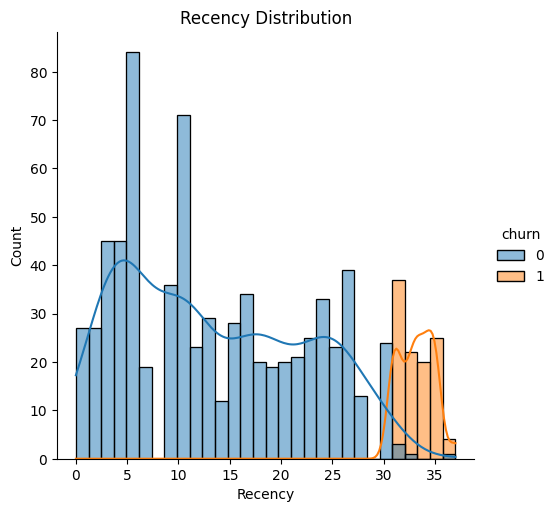

In [68]:
# check distribution
sns.displot(data=eda_rfm_data, x='Recency', hue='churn', kde=True, bins=30)
plt.title('Recency Distribution')

### 5.14 Tenure
---

In [69]:
# show descriptive stats
eda_rfm_data['Tenure'].describe()

,Tenure
count,830.000000
mean,4.234940
std,8.846308
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,35.000000


Text(0.5, 1.0, 'Tenure Distribution')

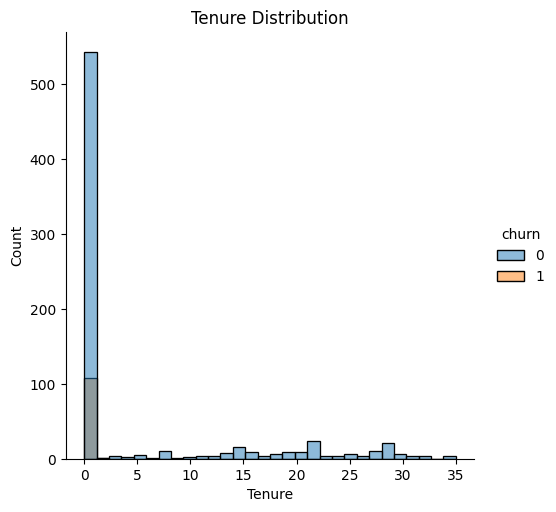

In [70]:
# check distribution
sns.displot(eda_rfm_data, x='Tenure', hue='churn', bins=30)
plt.title('Tenure Distribution')

In [71]:
# show tenure when the frequency is 1
eda_rfm_data[eda_rfm_data['Frequency'] == 1]['Tenure'].value_counts()

,count
Tenure,
0,608


### 5.15 Frequency
---

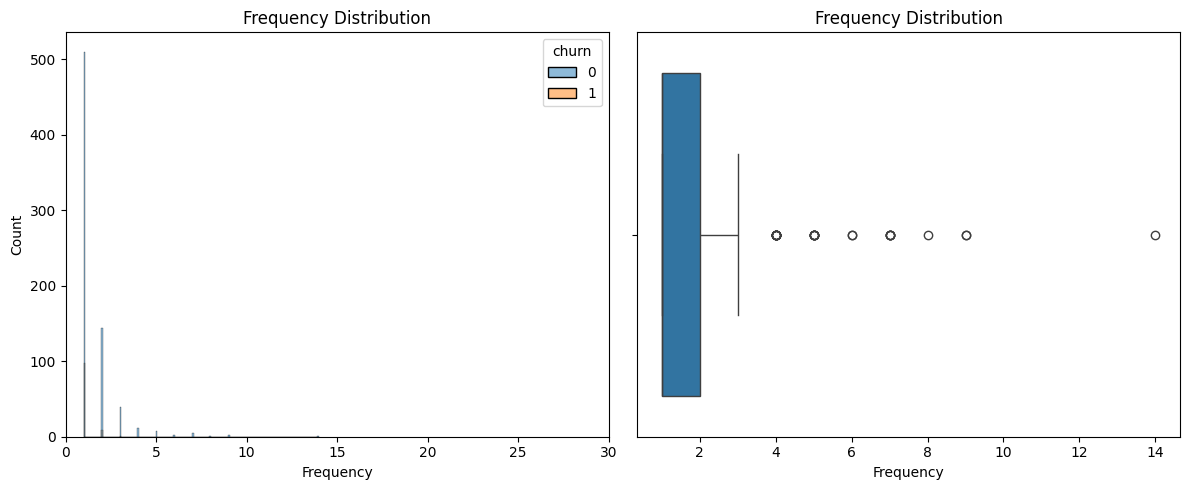

In [72]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Frequency Distribution
sns.histplot(eda_rfm_data, x='Frequency', hue='churn', bins=150, ax=axes[0])
axes[0].set_title('Frequency Distribution')
axes[0].set_xlim(0, 30)

# Plot 2: Boxplot
sns.boxplot(x='Frequency', data=eda_rfm_data, ax=axes[1])
axes[1].set_title('Frequency Distribution')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [73]:
# show Churn when the frequency is 1
eda_rfm_data[eda_rfm_data['Frequency'] == 1]['churn'].value_counts(normalize=True)*100

,proportion
churn,
0,83.881579
1,16.118421


### 5.16 Monetary
---

In [74]:
eda_rfm_data['Monetary'].describe()

,Monetary
count,830.000000
mean,4592.218060
std,9465.029327
min,23.320000
25%,1268.215000
50%,2564.040000
75%,4607.692500
max,169357.160000


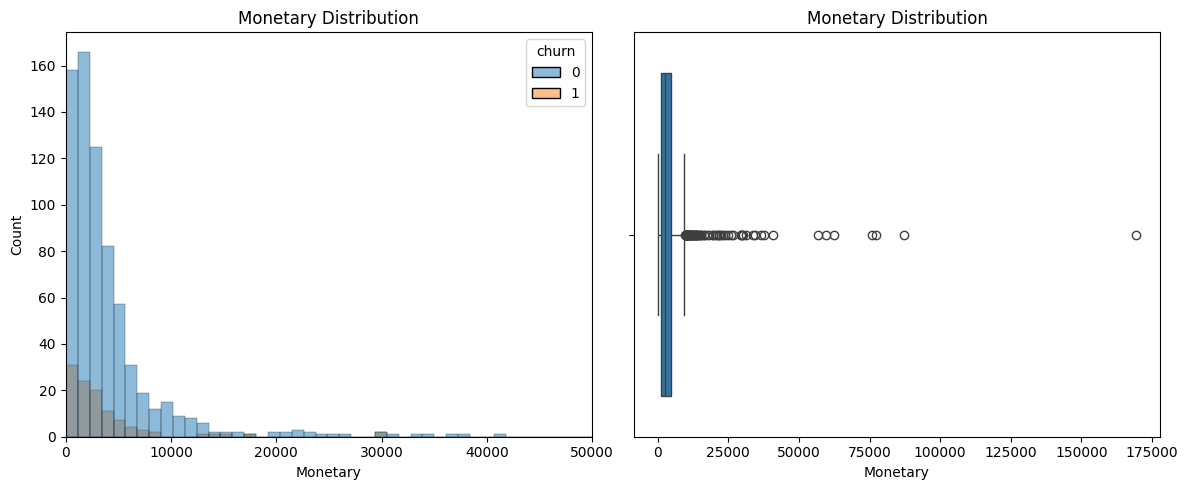

In [75]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Monetary Distribution
sns.histplot(eda_rfm_data, x='Monetary', hue='churn', bins=150, ax=axes[0])
axes[0].set_title('Monetary Distribution')
axes[0].set_xlim(0, 50000)

# Plot 2: Boxplot
sns.boxplot(x='Monetary', data=eda_rfm_data, ax=axes[1])
axes[1].set_title('Monetary Distribution')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### 5.17 AOV
---

In [76]:
# describe
eda_rfm_data['AOV'].describe()

,AOV
count,830.000000
mean,393.693711
std,976.284465
min,13.020000
25%,109.595000
50%,198.780000
75%,323.672500
max,15004.800000


Text(0.5, 1.0, 'AOV Distribution')

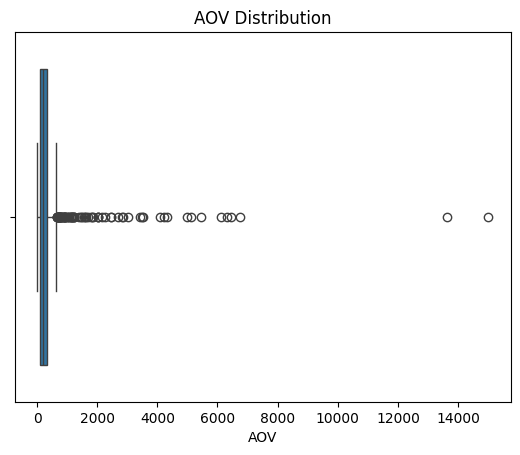

In [77]:
# Plot : Boxplot
sns.boxplot(x='AOV', data=eda_rfm_data)
plt.title('AOV Distribution')

### 5.18 Response Variable: Churn
---

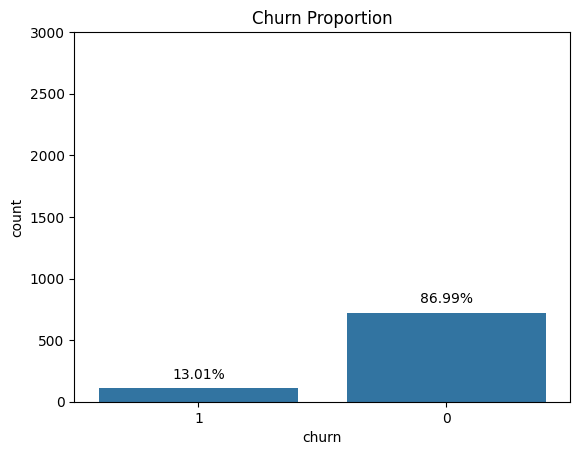

In [78]:
# Generate the countplot
ax = sns.countplot(data=eda_rfm_data, x='churn',
                   order=eda_rfm_data['churn'].value_counts().index[::-1])

# Calculate the percentage of each category
churn_counts = eda_rfm_data['churn'].value_counts(normalize=True)
churn_percentage = np.round(churn_counts * 100, 2)

# Add count annotations to each bar
for p, percentage in zip(ax.patches, churn_percentage[::-1]):
    ax.annotate(f"{percentage}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# set y limit
plt.ylim(0,3000)

# Set plot title
plt.title('Churn Proportion')

# Show the plot
plt.show()

### 5.19 Check the Data
---

In [79]:
# check dimension
print(f"Number of customers before droping outliers: {eda_rfm_data.shape[0]}")

Number of customers before droping outliers: 830


### 5.20. Handle Outlier
---

In [80]:
# Drop the outlier
def drop_outlier(data, cols):
    """
    Function to drop outliers by IQR

    Parameters
    ----------
    data : pandas Dataframe
        The sample data

    cols : list
        Cols to clean

    Return
    ------
    data_clean : pandas Dataframe
        The clean sample data
    """

    ubs, lbs = [], []

    # Find list ub & lb
    for col in cols:
        # Find iqr
        q1, q3 = np.quantile(data[col], q=[0.25, 0.75])
        iqr = q3-q1
        ub = q3 + 1.5*iqr
        lb = q1 - 1.5*iqr

        # Save ub & lb
        ubs.append(ub)
        lbs.append(lb)

    # Filter
    for i, col in enumerate(cols):
        cond_data_1 = data[col] <= ubs[i]
        cond_data_2 = data[col] >= lbs[i]
        data_clean = data[cond_data_1 & cond_data_2]

    return data_clean

In [81]:
# Remove outlier
eda_rfm_clean = drop_outlier(data = eda_rfm_data,
                             cols = ['Monetary', 'Frequency', 'AOV'])

# Validate
print('EDA Clean data shape :', eda_rfm_clean.shape)
eda_rfm_clean.describe()

EDA Clean data shape : (753, 6)


,Recency,Tenure,Frequency,Monetary,AOV,churn
count,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000
mean,15.864542,4.037185,1.403718,3306.946401,204.367331,0.128818
std,10.494818,8.687616,0.982066,3745.744245,131.115103,0.335221
min,0.000000,0.000000,1.000000,23.320000,13.020000,0.000000
25%,6.000000,0.000000,1.000000,1223.380000,102.420000,0.000000
50%,14.000000,0.000000,1.000000,2328.690000,181.430000,0.000000
75%,24.000000,0.000000,2.000000,4145.620000,276.220000,0.000000
max,37.000000,35.000000,14.000000,36545.610000,629.870000,1.000000


### 5.21 Visualize Clean Data
---

<ipython-input-82-adbd8a3021fe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=eda_rfm_clean[eda_rfm_clean.columns[col]], palette='viridis')
<ipython-input-82-adbd8a3021fe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=eda_rfm_clean[eda_rfm_clean.columns[col]], palette='viridis')
<ipython-input-82-adbd8a3021fe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=eda_rfm_clean[eda_rfm_clean.columns[col]], palette='viridis')
<ipython-input-82-adbd8a3021fe>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and 

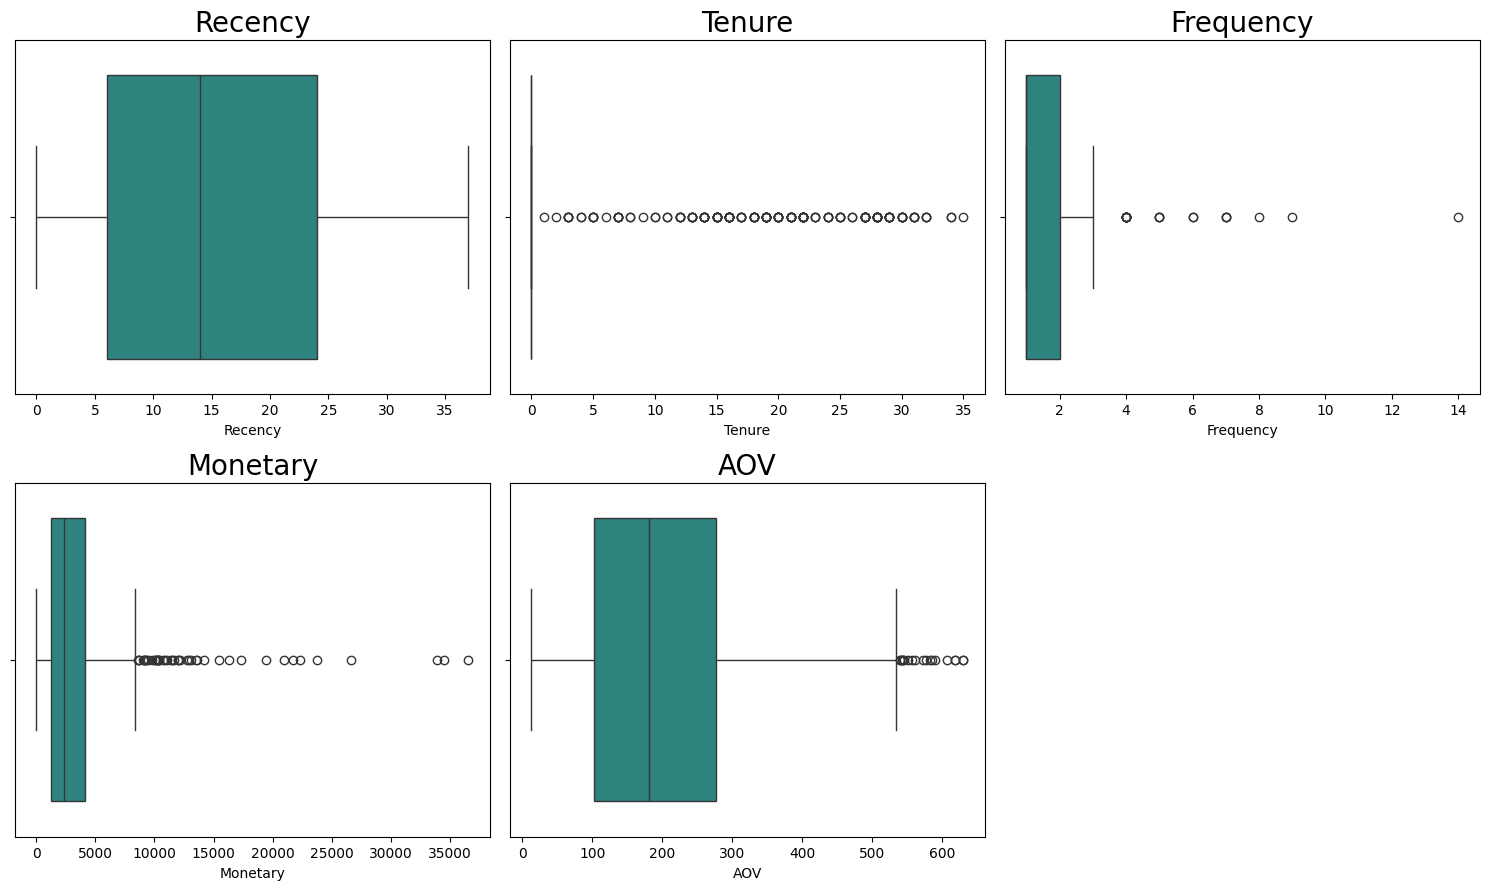

In [82]:
plt.figure(figsize=(15,13))
for col in range(0, len(eda_rfm_clean.columns)-1):
    plt.subplot(3,3,col+1)
    sns.boxplot(x=eda_rfm_clean[eda_rfm_clean.columns[col]], palette='viridis')
    plt.title(eda_rfm_clean.columns[col], fontsize=20)
    plt.tight_layout()

# 6. Data Preprocessing
---

- We need to clean our data (remove outliers)
- Split input and output
- Balancing the label (our target variable is imbalance)

## 6.1 Data Cleaning
---

In [83]:
def clean_data(transaction_data,
               anotation_data,
               reference_date,
               remove_outliers=True):
    """
    Function to preprocess the raw data to clean data

    Parameter
    ---------

    data: pandas dataframe
          input data train set or test set

    observation_log: pandas dataframe
          input data observation log

    remove_outliers: function
          function to remove outliers, default = true

    reference_date : object
           max allowable date

    Return
    ------

    df_rfm_clean: pandas dataframe
           clean data with generated variables and target variable
    """

    # 1. Generate RFM + T + AOV
    df_rfm = generate_rfmts(transaction_data, reference_date = reference_date)

    # 2. filted anotation data
    df_anot_filtered = filter_anotation_customer(data_anotation = anotation_data,
                                                data_transaction = df_rfm)
    # 3. define churn label
    churn_label = create_churn_anotation(anotation_data = df_anot_filtered)

    # 4. Assign churn variable
    df_rfm['Churn'] = churn_label

    # 5. Remove outliers
    if remove_outliers:
        df_rfm = drop_outlier(data=df_rfm, cols=['Monetary', 'Frequency', 'AOV'])
    else:
        df_rfm = df_rfm

    return df_rfm

In [84]:
train_clean =  clean_data(transaction_data = train_data,
                          anotation_data = data_his_for_anotation,
                          remove_outliers=True,
                          reference_date=train_data['Date'].max())

# print data dimenstion
train_clean.shape

<ipython-input-51-29fdb5aed866>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sales'] = data['Quantity'] * data['Price']
<ipython-input-61-317a5aa66e42>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation_data['n_transaction'] = np.sum(anotation_data, axis=1)
<ipython-input-61-317a5aa66e42>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

(753, 6)

In [85]:
print(train_clean.shape)
train_clean.head()

(753, 6)


,Recency,Tenure,Frequency,Monetary,AOV,Churn
CustomerNo,,,,,,
12160,16,0,1,51.2,51.20,0
12221,4,0,1,10371.0,120.59,0
12230,4,0,1,16299.9,239.70,0
12350,24,0,1,61.4,61.40,0
12610,3,20,2,7486.1,220.18,0


## 6.2 Split Input-Output
---

In [86]:
# function split input and output
def split_input_output(data, target_column):
    """
    Function to split input (x) and output (y)

    Parameters
    ----------
    data: pandas dataframe
          dataframe input

    target_column: string
          output column name

    Return
    ------

    x: pandas dataframe
          input data

    y: pandas dataframe
          output data

    """
    X = data.drop(columns = target_column)
    y = data[target_column]

    return X, y

# 7. Modelling
---
- Preprocessing Test Data
- Baseline Model
- Machine Learning Model
- Evaluation

In [87]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix

## 7.1 Clean Valid Data
---

In [88]:
valid_clean =  clean_data(transaction_data = valid_data,
                          anotation_data = data_his_for_anotation,
                          reference_date=valid_data['Date'].max(),
                          remove_outliers=False)

# print data dimenstion
valid_clean.shape

<ipython-input-51-29fdb5aed866>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sales'] = data['Quantity'] * data['Price']
<ipython-input-61-317a5aa66e42>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation_data['n_transaction'] = np.sum(anotation_data, axis=1)
<ipython-input-61-317a5aa66e42>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

(104, 6)

In [89]:
x_valid, y_valid = split_input_output(data = valid_clean,
                                      target_column = 'Churn')

## 7.2 Finding Best Model
---

We want to make churn use a logistic regression model for easy interpretation.

The models we will compare
1. Basic model --> (most frequent occurancy)
2. Logistic regression

The measurement performance model uses the AUC metric.

In [90]:
from sklearn.metrics import roc_auc_score

In [91]:
def fit_eval_model(model, x_train, y_train, x_valid, y_valid):
    """
    Fit & evaluate model with AUC as its scoring metrics.

    Parameters
    ----------
    model : sklearn object
        The estimator.

    x_train : pandas DataFrame
        Sample of input train

    x_valid : pandas DataFrame
        Sample of input valid

    y_train : pandas series
         Sample of output train data.

    y_valid : pandas series
        Sample of output valid data.


    Returns
    -------
    model_summary : dict
        Store model performance on train & valid set.
    """
    # Fit the model
    model.fit(x_train, y_train)

    # Predict the class probability for the given train & valid set
    y_train_pred = model.predict_proba(x_train)[:, 1]
    y_valid_pred = model.predict_proba(x_valid)[:, 1]

    # Calculate the performance on train & valid data
    auc_train = roc_auc_score(y_train, y_train_pred, average='weighted')
    auc_valid = roc_auc_score(y_valid, y_valid_pred, average='weighted')

    # Summarize the model
    model_summary = pd.DataFrame({'AUC train': [auc_train],
                                  'AUC valid': [auc_valid]})

    return model_summary


In [92]:
# Import Pacakage
from sklearn.dummy import DummyClassifier

In [93]:
# create dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

In [96]:
# Split input and output for the training data
x_train, y_train = split_input_output(data=train_clean, target_column='Churn')

# Get the model performance
summary_baseline = fit_eval_model(model=dummy_clf,
                                  x_train=x_train,
                                  y_train=y_train,
                                  x_valid=x_valid,
                                  y_valid=y_valid)

In [97]:
# add model name
summary_baseline['Model'] = 'Baseline'

# Rearrange the columns
summary_baseline.columns = ['AUC train', 'AUC valid', 'Model']

# show
summary_baseline

,AUC train,AUC valid,Model
0,0.5,0.5,Baseline


In [98]:
# Import Package
from sklearn.linear_model import LogisticRegression

In [99]:
# Create modeling object
lr_clf = LogisticRegression(penalty = None,
                            class_weight = 'balanced',
                            max_iter = 10000)

In [100]:
# Get the model performance
summary_logreg = fit_eval_model(model = lr_clf,
                                x_train = x_train,
                                y_train = y_train,
                                x_valid = x_valid,
                                y_valid = y_valid)

In [101]:
# add model name
summary_logreg['Model'] = 'Logistic Regression'

# concat baseline with logistic regression
summary_result = pd.concat([summary_baseline, summary_logreg],
                           ignore_index=True)

# show
summary_result

,AUC train,AUC valid,Model
0,0.500000,0.500000,Baseline
1,0.997596,0.993157,Logistic Regression


## 7.3 Finding Best Threshold
---

**FP & FN**

- FP = False Positive, predicted as churn (positive), in fact they're not churner
- FN = False Negative, predicted as not churn (negative), in fact they're churner


**Recall our cost information**

- cost acquisition (cost to acquire new customers) --> \$50 / customer
- cost reactivation (cost to retain existing customers) --> \$15 / customer

**Conclution**

- if we give reactivation treatment to non-churner (FP), we only lose \$15 per customer
- but if we lose a customer (it means we need to acquire), we'll lose $50.
- Meaning that it is more risky for people who originally churn but failed to be predicted (or false negative)

**Objective**

- Minimize False Negative

------
- After finding the best model, we need to find the best threshold for our model
- We need to find appropriate threshold based on our model objective --> minimize FN or highest TPR (recall)
- Then we need to set which evaluation metrics suitable for the objective
- We choose recall as our objective is minimize False Negative
- We need to minimze False Negative because acquire new customers is way more expensive than retaining customers

In [102]:
from sklearn.metrics import recall_score

In [103]:
def get_best_threshold(x_valid, y_valid, model):
    """
    Function to tune & get the best decision threshold

    Parameters
    ----------
    x_valid : pandas dataframe
        predictors validation set dataframe

    y_valid : pandas series
        target variable validation set

    model : object
        fitted model

    Returns
    ------
    best_threshold : float
        best threshold for precision score


    """
    # set threshold candidate
    thresholds = np.linspace(0, 1, 100)

    # Get the prediction probability
    y_pred_proba = model.predict_proba(x_valid)[:, 1]

    # Initialize
    metric_threshold = pd.Series([])

    # Optimize
    for threshold_value in thresholds:
        # Get predictions
        y_pred = (y_pred_proba >= threshold_value).astype(int)

        # Get the precision score
        metric_score = recall_score(y_valid, y_pred, average='weighted')

        # Add to metric_score
        metric_threshold[metric_score] = threshold_value

    # Find the threshold @max metric score
    metric_score_max_index = metric_threshold.index.max()
    best_threshold = metric_threshold[metric_score_max_index]
    print('=============================================')
    print('Best threshold :', best_threshold)
    print('Metric score   :', metric_score_max_index)
    print('=============================================')

    # Return threshold
    return best_threshold

In [104]:
best_threshold = get_best_threshold(x_valid = x_valid,
                                    y_valid = y_valid,
                                    model = lr_clf)

Best threshold : 0.8787878787878789
Metric score   : 0.9903846153846154


In [105]:
best_threshold

np.float64(0.8787878787878789)

In [106]:
def plot_roc_curve(y_true, y_score, threshold=None):
    """
    Plot the Receiver Operating Characteristic (ROC) curve for a binary classification model.

    Parameters:
    -----------
    y_true : pandas series
        True binary labels indicating the ground truth.

    y_score : pandas series
        Target scores or predicted probabilities from the model.

    threshold : float or None, optional
        Threshold value for marking a specific point on the ROC curve.
    """

    # Calculate sensitivity (TPR) and 1-specificity (FPR) from each possible threshold
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)

    # Calculate AUC score
    auc = roc_auc_score(y_true=y_true, y_score=y_score)
    auc = round(auc, 4)

    # Plot ROC curve
    plt.plot(fpr, tpr, label="AUC Model = " + str(auc))

    if threshold is not None:
        # Find the closest threshold index to the specified threshold value
        threshold_idx = np.abs(thresholds - threshold).argmin()

        # Plot the threshold point on the curve
        plt.scatter(fpr[threshold_idx], tpr[threshold_idx], color='red', marker='o')
        plt.text(fpr[threshold_idx], tpr[threshold_idx]+0.01, f"{threshold:.2f}", fontsize=8, ha='right', va='bottom')

        # Extract TPR and FPR values for the specified threshold
        tpr_value = tpr[threshold_idx]
        fpr_value = fpr[threshold_idx]
        print(f"For Threshold = {threshold:.2f}: TPR = {tpr_value:.4f}, FPR = {fpr_value:.4f}")

    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.legend(loc=4)
    plt.show()

In [107]:
y_valid_prob = lr_clf.predict_proba(x_valid)

For Threshold = 0.88: TPR = 1.0000, FPR = 0.0108


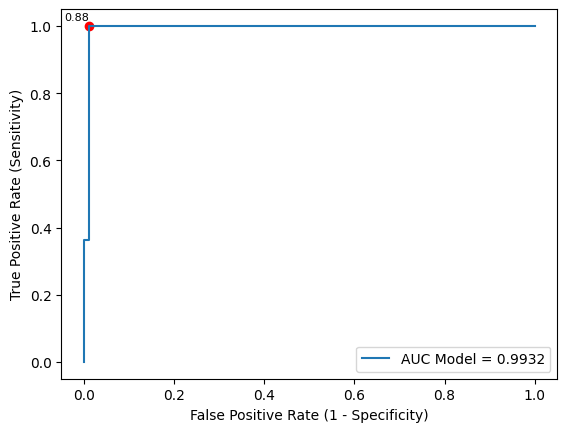

In [108]:
plot_roc_curve(y_true = y_valid,
               y_score = y_valid_prob[0:,1],
               threshold = best_threshold)

## 7.4 Evaluate in Test Set
---

In [109]:
test_clean =  clean_data(transaction_data = test_data,
                         anotation_data = data_his_for_anotation,
                         reference_date = test_data['Date'].max(),
                         remove_outliers = False)

# print data dimenstion
test_clean.shape

<ipython-input-51-29fdb5aed866>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sales'] = data['Quantity'] * data['Price']
<ipython-input-61-317a5aa66e42>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation_data['n_transaction'] = np.sum(anotation_data, axis=1)
<ipython-input-61-317a5aa66e42>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

(104, 6)

In [110]:
x_test, y_test = split_input_output(data = test_clean,
                                    target_column = 'Churn')

In [111]:
# Predict probabilities
y_test_prob = lr_clf.predict_proba(x_test)[:, 1]

# Predict based on the threshold
y_test_pred = (y_test_prob >= best_threshold).astype(int)

# Print Result
print('Testing RESULT:')
print(f'Test Recall Score : {recall_score(y_test, y_test_pred)}')

Testing RESULT:
Test Recall Score : 1.0


## 4.5 Predict Future Data
---

In [112]:
def create_future_data(data_log_future, data_stamped):
    """
    Create x and y for future data based on the given log data.

    Parameters
    ----------
    data_log_future : pandas DataFrame
        Log data for future predictions.

    data_stamped : pandas DataFrame
        transaction data with datetime features (stamped data)

    Returns
    -------
    x_future : pandas DataFrame
        Input features (x) for future data.

    y_future : pandas Series or array-like
        Target variable (y) for future data.
    """
    log_period_future, df_future_for_anotation = log_period_separation(log_data = data_log_future,
                                                                       obs_period = 5,
                                                                       time = '2019-12-11')

    transaction_df_future = assign_customer_id(data_log = log_period_future,
                                               data_stamped = data_stamped,
                                               date='2019-11-10')

    transaction_data_future = remove_unnecessary_cols(data = transaction_df_future)

    future_df_clean =  clean_data(transaction_data = transaction_data_future,
                                  anotation_data = df_future_for_anotation,
                                  reference_date = '2019-11-10',
                                  remove_outliers=False)

    x_future, y_future = split_input_output(data = future_df_clean,
                                            target_column = 'Churn')

    return x_future, y_future

In [113]:
x_future, y_future = create_future_data(data_log_future = data_log_future,
                                        data_stamped = data_stamped)

<ipython-input-61-317a5aa66e42>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation_data['n_transaction'] = np.sum(anotation_data, axis=1)
<ipython-input-61-317a5aa66e42>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anotation_data['churn'] = np.where(anotation_data['n_transaction'] == 0, 1, 0)


In [114]:
x_future.shape, y_future.shape

((2650, 5), (2650,))

In [115]:
# Predict probabilities
y_future_prob = lr_clf.predict_proba(x_future)[:, 1]

# Predict based on the threshold
y_future_pred = (y_future_prob >= best_threshold).astype(int)

# Print Result
print('Future RESULT:')
print(f'Recall Score : {recall_score(y_future, y_future_pred,average="weighted")}')

Future RESULT:
Recall Score : 0.4060377358490566


# 8. Decile Analysis
---

In [116]:
# print total number of customers
print(f'Number of customers : {x_future.shape[0]}')

Number of customers : 2650


In [117]:
def build_lift_data(model, X, y):
    """
    Build a lift curve based on the given model's predictions.

    Parameters
    ----------
    model : object
        The trained model with a `predict_proba` method.

    X : array-like or dataframe, shape (n_samples, n_features)
        The input features.

    y : array-like, shape (n_samples,)
        The true target labels.

    Returns
    -------
    rank_df: pandas DataFrame
        DataFrame containing the lift curve analysis at decile level.

    """
    # Step 1: Getting the Model Probabilities
    df = pd.concat([X, y], axis=1)
    y_pred_prob = model.predict_proba(X)[:, 1]
    df['pred_prob'] = y_pred_prob

    # Step 2: Create Deciles based on the Model Probabilities
    df['P_Rank'] = pd.qcut(df['pred_prob']
                   .rank(method='first').values, 10, duplicates='drop').codes + 1

    # Step 3: Summarize the data at Decile Level for Analysis
    rank_df = df.groupby('P_Rank')['Churn'].agg(['count', 'mean']).sort_values(by='P_Rank', ascending=False)
    rank_df.rename(columns={'mean': 'Actual_event_rate'}, inplace=True)

    # Step 4: Event Capture Analysis across Probability Deciles
    rank_df['N_events'] = rank_df['count'] * rank_df['Actual_event_rate']
    rank_df['cum_events'] = rank_df['N_events'].cumsum()
    rank_df['event_cap'] = rank_df['N_events'] / max(rank_df['N_events'].cumsum())
    rank_df['cum_event_cap'] = rank_df['event_cap'].cumsum()

    # Step 5: Non-Event Capture Analysis across Probability Deciles
    rank_df['N_non_events'] = rank_df['count'] - rank_df['N_events']
    rank_df['cum_non_events'] = rank_df['N_non_events'].cumsum()
    rank_df['non_event_cap'] = rank_df['N_non_events'] / max(rank_df['N_non_events'].cumsum())
    rank_df['cum_non_event_cap'] = rank_df['non_event_cap'].cumsum()

    # Step 6: Compute Lift over Baseline Event Rate
    rank_df['Baseline_Event_Rate'] = (max(rank_df['cum_events']) / max(rank_df['count'].cumsum()))
    rank_df['Lift_over_Avg'] = rank_df['Actual_event_rate'] / rank_df['Baseline_Event_Rate']

    rank_df = rank_df.reset_index()
    rank_df['Decile'] = rank_df.index + 1

    return rank_df

In [118]:
rank_df = build_lift_data(model = lr_clf,
                          X = x_future,
                          y = y_future)

## 8.1 Decile Distribution
---

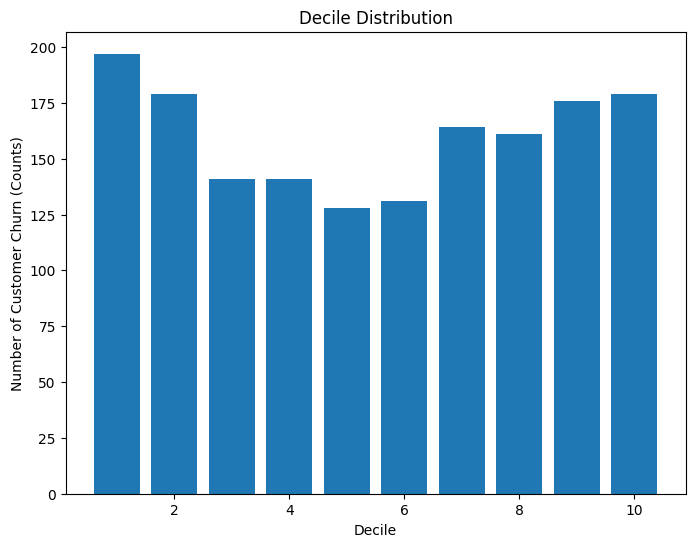

In [119]:
plt.figure(figsize=(8, 6))
plt.bar(rank_df['Decile'], rank_df['N_events'])
plt.xlabel('Decile')
plt.ylabel('Number of Customer Churn (Counts)')
plt.title('Decile Distribution')
plt.show()

## 8.2 Lift Curve
---

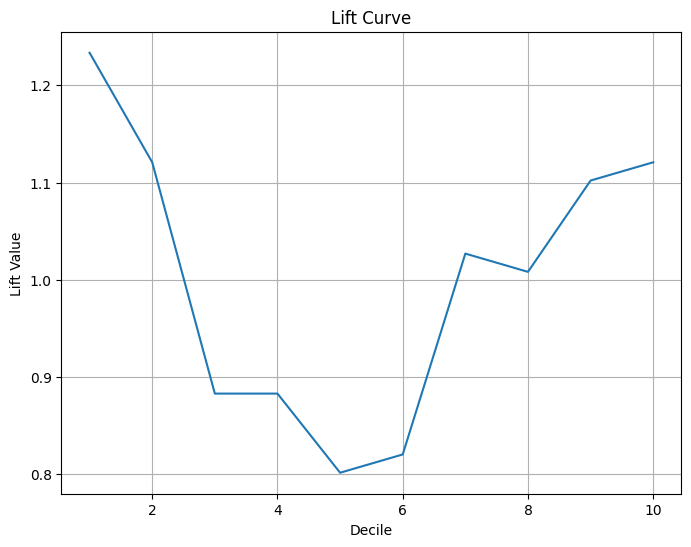

In [120]:
plt.figure(figsize=(8, 6))
plt.plot(rank_df['Decile'], rank_df['Lift_over_Avg'])
plt.grid()
plt.xlabel('Decile')
plt.ylabel('Lift Value')
plt.title('Lift Curve')
plt.show()

## 8.3 Cummulative Churn Rate
---

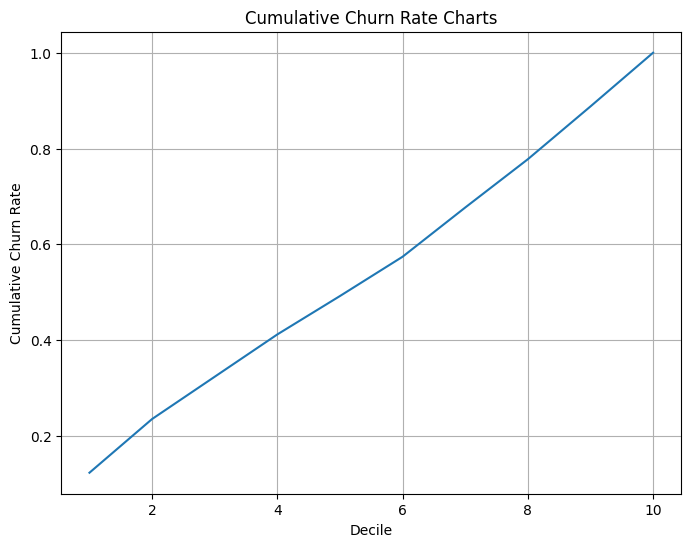

In [121]:
plt.figure(figsize=(8, 6))
plt.plot(rank_df['Decile'], rank_df['cum_event_cap'])
plt.xlabel('Decile')
plt.ylabel('Cumulative Churn Rate')
plt.grid()
plt.title('Cumulative Churn Rate Charts')
plt.show()


# 9. Interpretation
---

In [122]:
def get_coeff(clf, feature_name):

    """
    Parameters
    ----------
    clf : object
        fitted model (our best model)

    feature_name: list
        list of feature name
    Return
    ------

    df: pandas DataFrame
        Dataframe of coefficient name and coefficient value
    """

    # coefficients (slope)
    feature_importance = (pd.DataFrame({'variable': feature_name,
                                        'coefficient': clf.coef_[0]}))

    # rounding
    feature_importance = feature_importance.round(decimals=6)

    # sort values
    feature_importance = feature_importance.sort_values('coefficient',
                                                        ascending=False)

    # coefficient (intercept)
    intercept = pd.DataFrame({'variable': 'intercept',
                              'coefficient': clf.intercept_[0]},
                            index=[len(feature_importance)])

    # concat
    df = pd.concat([feature_importance, intercept])

    # get exponential of our coefficient
    df['exp'] = np.exp(df['coefficient'])


    return df

In [123]:
get_coeff(clf = lr_clf, feature_name = x_future.columns)

,variable,coefficient,exp
0,Recency,2.908892,1.833647e+01
1,Tenure,1.150210,3.158856e+00
2,Frequency,0.517352,1.677580e+00
3,Monetary,0.000214,1.000214e+00
4,AOV,-0.002700,9.973036e-01
5,intercept,-88.360065,4.223878e-39


`Intercept:`

- The estimated odds of a customer churning when all variables are equal to 0 is approximately or 0.000004
- In simple terms, if no customer action is taken, So the probability of customer will churn is < 0.5 when all variabes are equal to 0
- We can make hypothesis/guesses,customers will not churn if they doing nothing
`Recency:`

- For every unit increase in recency, the odds of customer churn increase by a factor of exp(0.081211) or approximately 1.09 (indeed it's small odds of customer churn)
- This suggests that longer purchase activity is associated with a higher likelihood of churn.
- It is important to engage with customers who have a low recency value to reduce the chances of churn

**Initiative:**
- Focus on customer who have a low recency value
- Personalized offers, or timely notifications to keep them actively engaged with your ecommerce platform.
- By providing incentives and attention to these recently active customers, you can reduce the likelihood of churn.
`Tenure:`

- For every unit increase in tenure, the odds of customer churn decrease by  approximately 0.99.
- This indicates that longer customer tenure is associated with a lower likelihood of churn. (but the odds is indeed small)
- Retaining customers for a longer duration is important to reduce churn

`Frequency:`

- For every unit increase in frequency, the odds of customer churn decrease by approximately 0.91
- This suggests that higher transaction frequency is associated with a lower likelihood of churn.
- Encouraging customers to make more frequent purchases can help reduce churn.

**Inititative:**
- Encourage customers to make more frequent purchases by offering loyalty programs, exclusive discounts, or incentives for repeat purchases.
- By increasing the transaction frequency, you can create a habit of shopping with your platform and build a loyal customer base, decreasing the chances of churn.

`AOV (Average Order Value):`
- For every unit increase in AOV, the odds of customer churn decrease by approximately 0.99 (It's small indeed)
- This suggests that higher average order values are associated with a slightly lower likelihood of churn.
- Encouraging customers to have higher order values can be beneficial in reducing churn.

**Initiative:**
- Enhance customers to increase their average order values by offering bundle deals, upselling, or cross-selling relevant products.
- Implement personalized recommendations based on their browsing and purchase history to enhance the value they receive from each transaction.
- Higher average order values contribute to stronger customer commitment and lower churn rates.